In [1]:
# want to store this notebook in the notebooks folder, but want to keep non-relative imports
import os
os.chdir("../..")


In [2]:
import sys
import data, data.gene_datasets, data.colombos
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import data.graph
from data.graph import Graph
import analysis
from analysis import monitoring
import main
import optimization as otim
from torch.autograd import Variable
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline  
plt.ioff()
%matplotlib notebook

/u/weissmar/venv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


ImportError: Traceback (most recent call last):
  File "/u/weissmar/venv/lib/python2.7/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/u/weissmar/venv/lib/python2.7/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/u/weissmar/venv/lib/python2.7/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
ImportError: libcudnn.so.7: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [ ]:
dataset = data.gene_datasets.DGEXGEO(nb_examples=2000)
class Object(object):
    pass

opt = Object()
opt.seed = 1
opt.nb_class = None
opt.nb_examples = None
opt.nb_nodes = None
opt.graph = "pathway"
opt.dataset = dataset
opt.add_self = True
opt.add_connectivity = False
opt.batch_size = 128

graph = Graph()
path = "/data/lisa/data/genomics/graph/pancan-tissue-graph.hdf5"
graph.load_graph(path)
graph.intersection_with(dataset)
g = nx.from_numpy_matrix(graph.adj)
mapping = dict(zip(range(0, len(dataset.df.columns)), dataset.df.columns))
g = nx.relabel_nodes(g, mapping)

In [3]:
dataset.df.shape

(2000, 10018)

In [113]:
import models.models
reload(models.models)
reload(analysis.monitoring)
# Get the model

#paths = ['./experiments/experiments/dgex/mlp/testing123/e08c193cbd2a8bfd6ec2de63606ffb4b/1', #MLP
#    './experiments/experiments/dgex/mlp/testing123/51173cb5165bffcd71779d60c631806a/1', # Logistic regression
#    './experiments/experiments/dgex/cgn/testing123/849def25b3317bf5904d8a4c021eb776/1', # cgn
#]

paths = {'mlp': './experiments/experiments/dgex/mlp/testing123/0aa717b82eeccbac094b8f40c0dbfc2e/1', #MLP
   'logistic': './experiments/experiments/dgex/mlp/testing123/81b383017af3702cc13c5e40d7eb7ec4/1', # Logistic regression
   'gcn': './experiments/experiments/dgex/cgn/testing123/4fb6d502cd652367515f5fc2294d4e15/1', # cgn
    'gcn+mlp':'./experiments/experiments/dgex/cgn+mlp/testing123/d48639803e20b19785d2c17da4e27f3f/1'
        }

load_folder = "./experiments/experiments/tcga-tissue-gene-inference/cgn/testing123/329006fa5a858bcbac9ffe480bfc1485/1993"
opt.load_folder = load_folder
opt.load_checkpoint = True
opt.epoch = 100
opt.training_mode = 'gene-inference'
#my_model, optimizer, epoch, saved_opt = analysis.monitoring.load_checkpoint(load_folder, 
#                                                                           opt, dataset, graph)

all_saved_model = {k: analysis.monitoring.load_checkpoint(p, opt, dataset, graph) for k, p in paths.items()}


=> loading checkpoint './experiments/experiments/dgex/mlp/testing123/0aa717b82eeccbac094b8f40c0dbfc2e/1/checkpoint.pth.tar'
Loading the model with these parameters: <__main__.Object object at 0x7f69f33b3490>
=> loaded checkpoint './experiments/experiments/dgex/mlp/testing123/0aa717b82eeccbac094b8f40c0dbfc2e/1/checkpoint.pth.tar' (epoch 500)
Doing Drop-out
Our model:
MLP (
  (my_layers): ModuleList (
    (0): Linear (10018 -> 512)
  )
  (last_layer): Linear (512 -> 10018)
  (my_dropout): Dropout (p = 0.5)
)
=> loading checkpoint './experiments/experiments/dgex/cgn+mlp/testing123/d48639803e20b19785d2c17da4e27f3f/1/checkpoint.pth.tar'
Loading the model with these parameters: <__main__.Object object at 0x7f69f33b3490>
=> loaded checkpoint './experiments/experiments/dgex/cgn+mlp/testing123/d48639803e20b19785d2c17da4e27f3f/1/checkpoint.pth.tar' (epoch 56)
Doing drop-out
Doing Drop-out
Our model:
Graph_plus_MLP (
  (graph_network): GraphNetwork (
    (emb): EmbeddingLayer (
    )
    (my_conv

In [114]:
# Get the dataset
saved_opt = all_saved_model['mlp'][-1]
train_set, valid_set, test_set = main.split_dataset(dataset, batch_size=12, seed = saved_opt.seed,
                                                   nb_samples=saved_opt.nb_examples, train_ratio=saved_opt.train_ratio, 
                                                    nb_per_class=saved_opt.nb_per_class)

In [116]:
def evaluate(my_model, eval_set, opt):
    
    dataset = eval_set.dataset
    
    results = []
    
    for no_b, mini in enumerate(eval_set):
        
        if no_b > 1000:
            break
        
        

        inputs, targets = mini['sample'], mini['labels']

        inputs = Variable(inputs, requires_grad=False).float()
        targets = Variable(targets, requires_grad=False).float()

        if opt.cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()
            my_model.cuda()

        # Forward pass: Compute predicted y by passing x to the model
        my_model.eval()

        y_pred = my_model(inputs)

        # Compute and print loss
        crit_loss = (y_pred - targets)**2  * (targets > 0.).float()
        crit_loss = crit_loss.cpu().data.numpy().mean(0)
        results.append(crit_loss)

    print "Done!"
    return np.array(results).mean(0)

results = {k: evaluate(p[0], valid_set, saved_opt) for k, p in all_saved_model.items()}

Done!


/u/dutilfra/.conda/envs/pytorch0.2/lib/python2.7/site-packages/torch/autograd/_functions/basic_ops.py:17: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return a.add(b)


Done!
Done!
Done!


In [99]:
results[2].shape

(10018, 1)

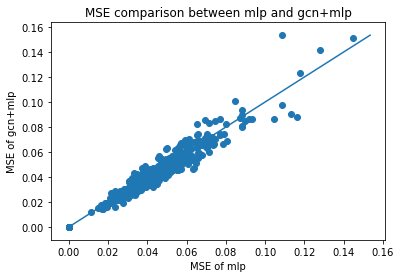

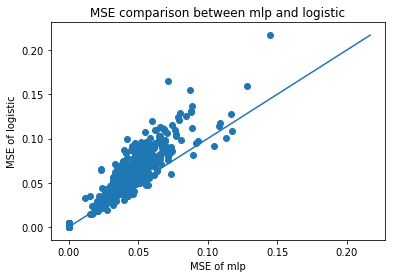

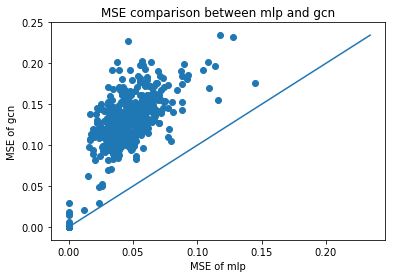

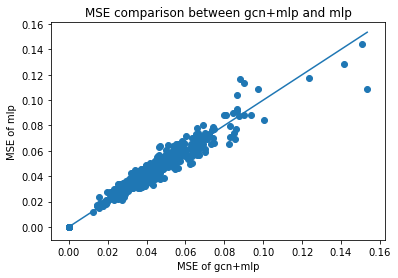

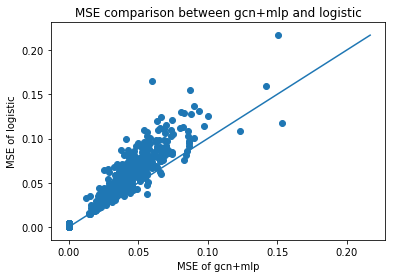

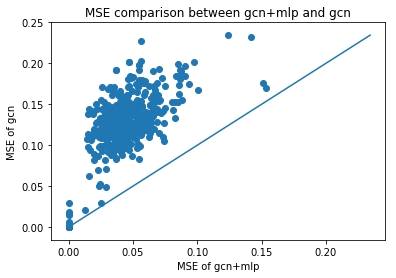

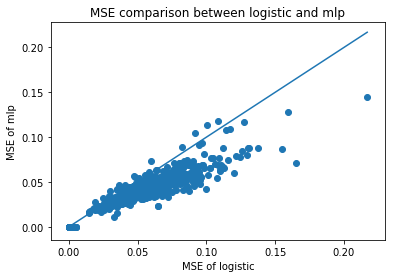

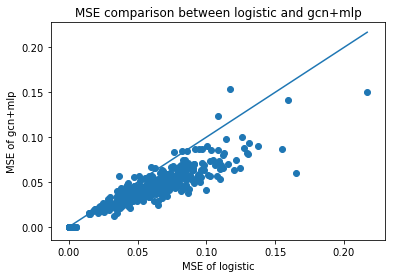

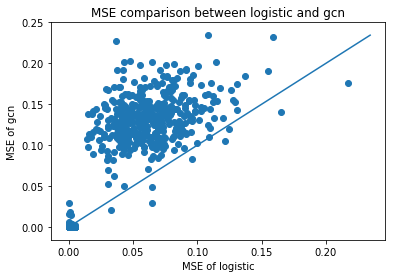

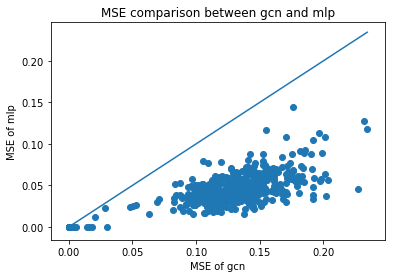

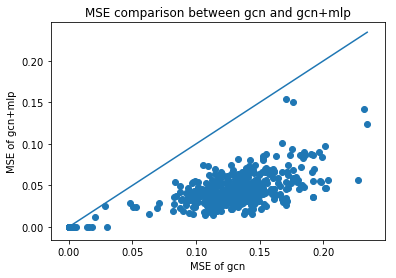

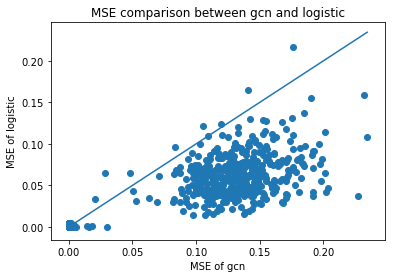

In [120]:
for m in results.keys():
    for m_2 in results.keys():
        if m == m_2:
            continue
            
        plt.title("MSE comparison between {} and {}".format(m, m_2))
        plt.xlabel("MSE of {}".format(m))
        plt.ylabel("MSE of {}".format(m_2))
        plt.plot([0, max(max(results[m]), max(results[m_2]))],[0, max(max(results[m]), max(results[m_2]))])
        plt.scatter(results[m], results[m_2])
        plt.show()
        

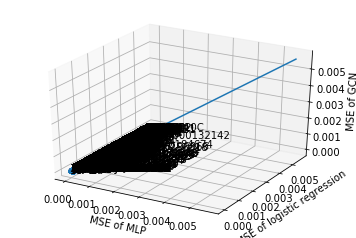

In [100]:
plt.ioff()

# plt.scatter(results[0].mean(axis=0), results[1].mean(axis=0))
# #plt.yscale('log')
# #plt.xscale('log')
# plt.plot([0, max(results[0].mean(axis=0))],[0, max(results[0].mean(axis=0))])
# plt.title("MSE comparison between MLP and logistic regression")
# plt.xlabel("MSE of logistic regression")
# plt.ylabel("MSE of MLP")
# plt.show()

# plt.title("MSE comparison between logistic regression and GCN")
# plt.xlabel("MSE of logistic regression")
# plt.ylabel("MSE of GCN")
# plt.plot([0, max(results[2].mean(axis=0))],[0, max(results[2].mean(axis=0))])
# plt.scatter(results[1].mean(axis=0), results[2].mean(axis=0))
# plt.show()

# plt.title("MSE comparison between MLP and GCN")
# plt.xlabel("MSE of MLP")
# plt.ylabel("MSE of GCN")
# plt.plot([0, max(results[2].mean(axis=0))],[0, max(results[2].mean(axis=0))])
# plt.scatter(results[0].mean(axis=0), results[2].mean(axis=0))
# plt.show()



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#ax.title("MSE comparison between models")
#ax.xlabel("MSE of MLP")
#ax.ylabel("MSE of logistic regression")
#plt.zlabel("MSE of GCN")



x_coor = results[0]
y_coor = results[1]
z_coor = results[2][:, -1]

to_keep = np.where((z_coor < x_coor) * (z_coor < y_coor))

ax.set_xlabel('MSE of MLP')
ax.set_ylabel('MSE of logistic regression')
ax.set_zlabel('MSE of GCN')
ax.plot([0, max(results[2].mean(axis=0))],[0, max(results[2].mean(axis=0))], [0, max(results[2].mean(axis=0))])
ax.scatter(x_coor[to_keep], y_coor[to_keep], z_coor[to_keep])

for i, txt in enumerate(dataset.node_names):
    #print i, txt
    if z_coor[i] < x_coor[i] and z_coor[i] < y_coor[i]:
        ax.text(x_coor[i], y_coor[i], z_coor[i], txt)


plt.show()

In [101]:
len(np.array(dataset.node_names)[to_keep])

6787

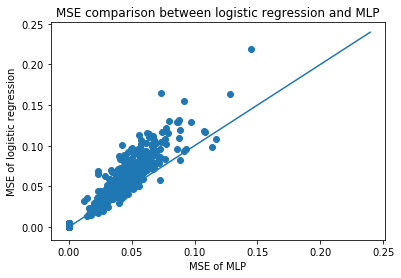

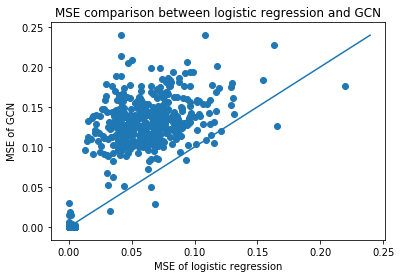

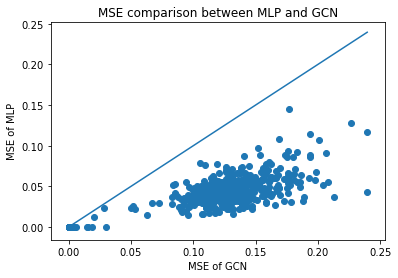

In [107]:
plt.title("MSE comparison between logistic regression and MLP")
plt.xlabel("MSE of MLP")
plt.ylabel("MSE of logistic regression")
plt.plot([0, max(max(y_coor), max(z_coor))],[0, max(max(y_coor), max(z_coor))])
plt.scatter(x_coor, y_coor)
plt.show()

plt.title("MSE comparison between logistic regression and GCN")
plt.xlabel("MSE of logistic regression")
plt.ylabel("MSE of GCN")
plt.plot([0, max(max(y_coor), max(z_coor))],[0, max(max(y_coor), max(z_coor))])
plt.scatter(y_coor, z_coor)
plt.show()

plt.title("MSE comparison between MLP and GCN")
plt.xlabel("MSE of GCN")
plt.ylabel("MSE of MLP")
plt.plot([0, max(max(x_coor), max(z_coor))],[0, max(max(x_coor), max(z_coor))])
#plt.plot([0, 1],[0, 1])
diff = (z_coor - x_coor) != 0.
plt.scatter(z_coor[diff], x_coor[diff])
plt.show()

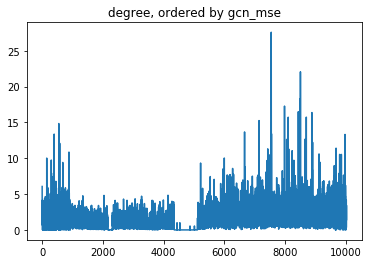

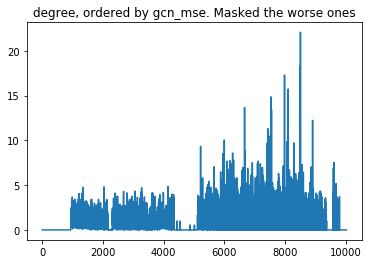

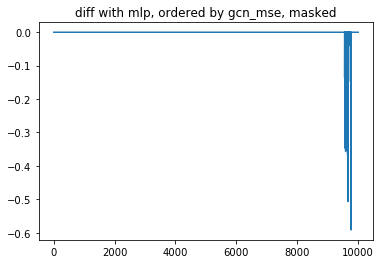

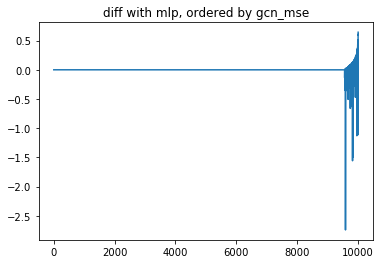

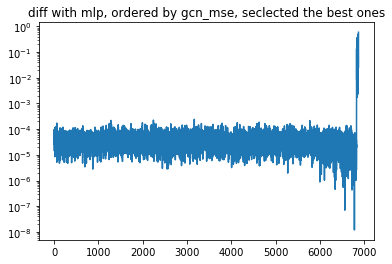

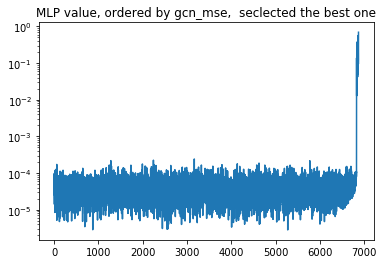

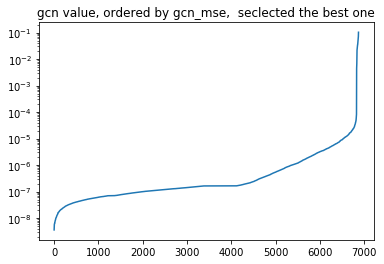

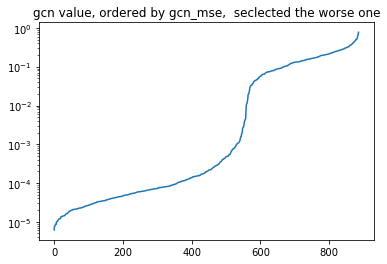

In [15]:
plt.title("degree, ordered by gcn_mse")
coor = np.argsort(z_coor)
plt.plot(graph.adj.sum(axis=0)[coor])
plt.show()

plt.title("degree, ordered by gcn_mse. Masked the worse ones")
coor = np.argsort(z_coor)
plt.plot((graph.adj.sum(axis=0) * (z_coor < x_coor) * (z_coor < y_coor))[coor])
plt.show()

#plt.plot((graph.adj.dot(graph.adj).sum(axis=0) * (z_coor < x_coor) * (z_coor < y_coor))[coor])
#plt.show()

plt.title("diff with mlp, ordered by gcn_mse, masked")
plt.plot(((z_coor - x_coor) * (z_coor < x_coor) * (z_coor < y_coor))[coor])
plt.show()

plt.title("diff with mlp, ordered by gcn_mse")
plt.plot((z_coor - x_coor)[coor])
plt.show()



plt.title("diff with mlp, ordered by gcn_mse, seclected the best ones")

coor = np.argsort(z_coor[to_keep])
plt.semilogy((-z_coor[to_keep] + x_coor[to_keep])[coor])
plt.show()

plt.title("MLP value, ordered by gcn_mse,  seclected the best one")
coor = np.argsort(z_coor[to_keep])
plt.semilogy((x_coor[to_keep])[coor])
plt.show()


plt.title("gcn value, ordered by gcn_mse,  seclected the best one")
coor = np.argsort(z_coor[to_keep])
plt.semilogy((z_coor[to_keep])[coor])
plt.show()


plt.title("gcn value, ordered by gcn_mse,  seclected the worse one")
worse_then = np.where((z_coor > x_coor))
coor = np.argsort(z_coor[worse_then])
plt.semilogy((z_coor[worse_then])[coor])
plt.show()

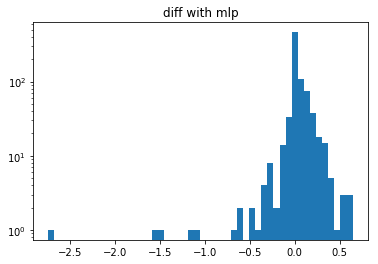

804
3971


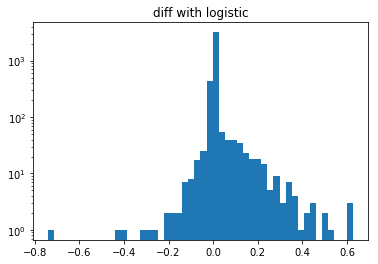

In [56]:
plt.title("diff with mlp")
#diff = (z_coor - x_coor) != 0.
diff =  np.abs((z_coor - x_coor)) > 1e-4
plt.hist((z_coor - x_coor)[diff],bins=50, log=True)
plt.show()
print diff.sum()

plt.title("diff with logistic")
diff =  np.abs((z_coor - y_coor)) > 1e-4
plt.hist((z_coor - y_coor)[diff],bins=50, log=True)
print diff.sum()
plt.show()

In [48]:
diff = (z_coor - x_coor) < -1e-4
print sorted(np.array(dataset.node_names)[diff])

['ABCB6', 'ACAA1', 'ACSL1', 'ADAM10', 'ADH5', 'ADRA1B', 'AGPAT4', 'AIMP2', 'AKR7A2', 'AMIGO2', 'ANKRD53', 'ANXA7', 'AP3B2', 'ARC', 'ARFGAP3', 'ARG2', 'ARHGEF38', 'ARL4C', 'ARMC8', 'ARPC1B', 'ASAP3', 'ATF5', 'ATP10B', 'ATP1B3', 'ATP6V1F', 'ATXN2', 'BAHD1', 'BAIAP2L2', 'BAX', 'BBS7', 'BCL2L13', 'BCL9', 'BHLHE40', 'BOK', 'BOLA1', 'C2CD2L', 'CADM4', 'CARD9', 'CARHSP1', 'CASP2', 'CCDC28A', 'CCDC85B', 'CCND1', 'CCNF', 'CCNG2', 'CCNK', 'CCT6B', 'CD101', 'CD1A', 'CD44', 'CDK2', 'CDKN2A', 'CEP131', 'CEP57', 'CFLAR', 'CHD1', 'CIAPIN1', 'CLEC11A', 'CLTB', 'CNBP', 'CNIH4', 'COL4A3', 'COMMD8', 'CRK', 'CRYZL1', 'CTNND1', 'DAXX', 'DCBLD2', 'DCTD', 'DCUN1D1', 'DCUN1D2', 'DDA1', 'DEPDC5', 'DHRS1', 'DHRS7', 'DRG2', 'DUSP4', 'DVL1', 'DVL3', 'ECI2', 'EDEM2', 'EED', 'EGFR', 'EGR1', 'EGR4', 'EIF1AX', 'EIF2B5', 'EIF4G1', 'ELK1', 'ELMO3', 'EML4', 'ENOSF1', 'ENSG00000168242', 'ENSG00000184348', 'EPHB2', 'ESPN', 'EXOSC4', 'EXT1', 'FAM182A', 'FAM204A', 'FBXO11', 'FBXO40', 'FEM1C', 'FFAR3', 'FKBP10', 'FLI1', 'FLR

In [54]:
index_rpl5 = dataset.node_names.index('RPL5')
z_coor[index_rpl5], x_coor[index_rpl5]

(1.7513685e-05, 4.7832054e-05)

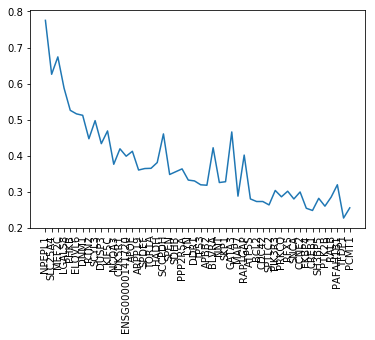

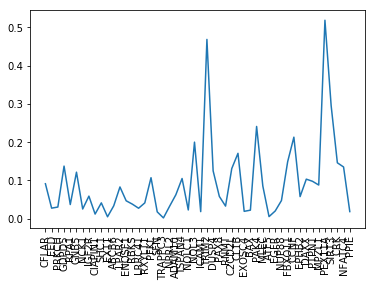

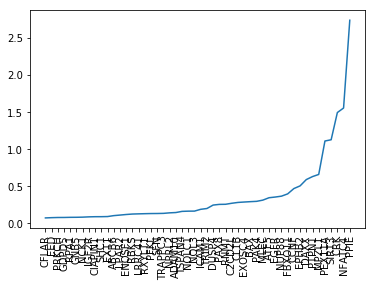

In [57]:
nb = 50
coor = np.argsort(-z_coor + x_coor)
plt.plot(z_coor[coor[:nb]])
plt.xticks(np.arange(nb), np.array(dataset.node_names)[coor[:nb]], rotation=90)
plt.show()

plt.plot(z_coor[coor[-nb:]])
plt.xticks(np.arange(nb), np.array(dataset.node_names)[coor[-nb:]], rotation=90)
plt.show()

plt.plot((-z_coor + x_coor)[coor[-nb:]])
plt.xticks(np.arange(nb), np.array(dataset.node_names)[coor[-nb:]], rotation=90)
plt.show()

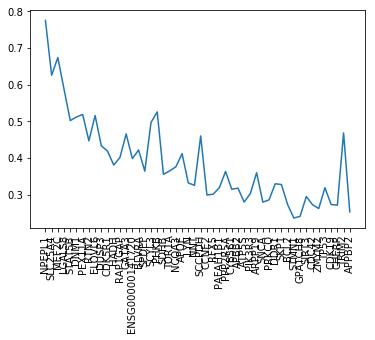

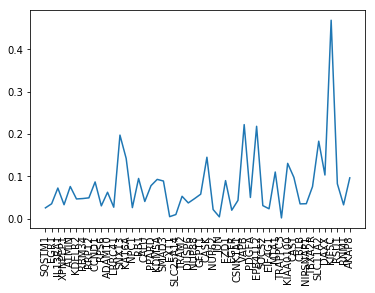

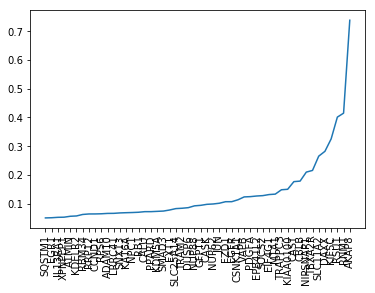

In [58]:
nb = 50
coor = np.argsort(-z_coor + y_coor)
plt.plot(z_coor[coor[:nb]])
plt.xticks(np.arange(nb), np.array(dataset.node_names)[coor[:nb]], rotation=90)
plt.show()

plt.plot(z_coor[coor[-nb:]])
plt.xticks(np.arange(nb), np.array(dataset.node_names)[coor[-nb:]], rotation=90)
plt.show()

plt.plot((-z_coor + y_coor)[coor[-nb:]])
plt.xticks(np.arange(nb), np.array(dataset.node_names)[coor[-nb:]], rotation=90)
plt.show()

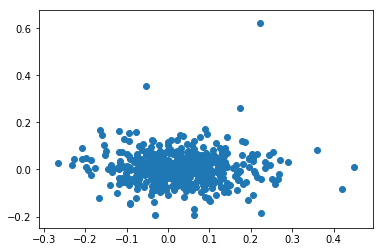

(10018, 2)

In [78]:
from sklearn.decomposition import PCA

emb = all_saved_model[-1][0].state_dict()['emb.emb'].cpu().numpy()
emb = all_saved_model[0][0].state_dict()['my_layers.0.weight'].cpu().numpy().T

pca = PCA(n_components=2)
coord = pca.fit_transform(emb)

plt.scatter(coord[:, 0], coord[:, 1])
plt.show()

coord.shape

In [76]:
all_saved_model[0][0].state_dict().keys()

['my_layers.0.weight',
 'my_layers.0.bias',
 'last_layer.weight',
 'last_layer.bias']